## Using the CASCADe-jitter package to determine telescope movement in JWST data ##

This notebook shows the basic functions of the <span style="color:#1F618D">CASCADe-jitter</span> modules to detect and characterize telescope movement. We demonstrate the use of the JitterDetection class of the  <span style="color:#1F618D">CASCADe-jitter</span> package on simulated data of the JWST/MIRI Low Resolution Spectrograph (LRS). The <span style="color:#1F618D">CASCADe-jitter</span> package is a sub-package of the <span style="color:#1F618D">CASCADe</span> transit spectroscopy package developed for the H2020 program Exopanets-A, and contains all functionality for detecting pointing jitter in spetroscopic timeseries. 

We start with importing all needed modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.io import ascii as ap_ascii
import pathlib
import os
from numpy.polynomial.polynomial import polyval

from cascade_filtering.filtering import DirectionalFilter
from cascade_filtering.kernel import FilterKernel

from cascade_jitter.utilities import create_mask_from_dq
from cascade_jitter.utilities import find
from cascade_jitter.jitter import JitterDetector, Tracer
from cascade_jitter.initialize import CASCADE_JITTER_EXAMPLE_DIR

%matplotlib inline

Next we defing the path settings to the needed configuration and data files.

In [2]:
CONFIG_PATH = pathlib.Path(CASCADE_JITTER_EXAMPLE_DIR) / 'config_files/'
DATA_PATH = pathlib.Path(CASCADE_JITTER_EXAMPLE_DIR) / 'data/MIRI/LRS/jittered_data/'
CAL_DATA_PATH = pathlib.Path(CASCADE_JITTER_EXAMPLE_DIR) / 'data/MIRI/LRS/calibration_files/'

print(f"The path to the configuration files is: {CONFIG_PATH}")

The path to the configuration files is: /home/bouwman/CASCADeSTORAGE/examples_jitter/config_files


Then we load the simulated data. The used data set consist of 26 integrations, each at a slightly different dither position:

In [3]:
files = find('*_rateints.fits', DATA_PATH)
image_file = pathlib.Path(files[0])
with fits.open(image_file) as hdul:
    print(hdul.info())
    spectral_image_cube = hdul['SCI'].data
    spectral_image_uncertainty = hdul['ERR'].data
    spectral_image_mask = hdul['DQ'].data
spectral_image_cube = spectral_image_cube.astype(float)
spectral_image_uncertainty = spectral_image_uncertainty.astype(float)
spectral_image_mask = create_mask_from_dq(spectral_image_mask.astype(int))

Filename: /home/bouwman/CASCADeSTORAGE/examples_jitter/data/MIRI/LRS/jittered_data/jitter_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     125   ()      
  1  SCI           1 ImageHDU        47   (72, 416, 26)   float32   
  2  ERR           1 ImageHDU        11   (72, 416, 26)   float32   
  3  DQ            1 ImageHDU        12   (72, 416, 26)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (72, 416, 26)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (72, 416, 26)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [4144B]   
None


For later comparison we also load the file containing for each integration the offset in pixels from the nominal pointing used for the simulated data set.

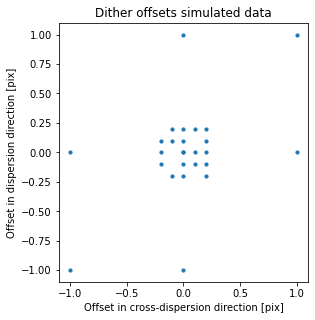

In [4]:
file = 'lrs_dithers.dat'
dither_positions = ap_ascii.read(DATA_PATH / file, names=['xpos', 'ypos']) 
fig, ax = plt.subplots(1,1, figsize=(5,5))
fig.tight_layout(pad=4.0)
ax.scatter(dither_positions['xpos'],dither_positions['ypos'], s=10)
ax.set_title('Dither offsets simulated data')
ax.set_xlabel('Offset in cross-dispersion direction [pix]')
ax.set_ylabel('Offset in dispersion direction [pix]')
plt.show()

Next we define a region of interest on the detector images in which we will do our analys and seach for the dispersed light of the target star. Note that in this simulation we could have used the entire array but we advice to use prior knowledge to limit the analysis area on the detector to save time and posibly cut out possible problematic data nto needed for the science goals. 

In [5]:
ROI = np.zeros_like(spectral_image_cube[0,...], dtype=bool)
# flag 8 pixels to the left and right of thr subarray
ROI[:, :9] = True
ROI[:, 68:] = True
# flag the top and bottowm parts of the sub array
ROI[:100, :] =True
ROI[-20:, :] =True

In [6]:
JD = JitterDetector(configuration_file='jitter_detector.conf', configuration_file_path=CONFIG_PATH)
JD.run_jitter_detection(spectral_image_cube,
                        spectral_image_mask, ROI)


Preprocessing Data
Determining Rotation and Scale


Reference Image:   0%|          | 0/2 [00:00<?, ?it/s]

Target Image:   0%|          | 0/26 [00:00<?, ?it/s]

Target Image:   0%|          | 0/26 [00:00<?, ?it/s]

Determiming Poining Movement


Reference Image:   0%|          | 0/1 [00:00<?, ?it/s]

Target Image:   0%|          | 0/26 [00:00<?, ?it/s]

Reference Image:   0%|          | 0/1 [00:00<?, ?it/s]

Target Image:   0%|          | 0/26 [00:00<?, ?it/s]

Select individual references of take median

In [7]:
movement = np.median(JD.source_shifts[:, :, :], axis=0)

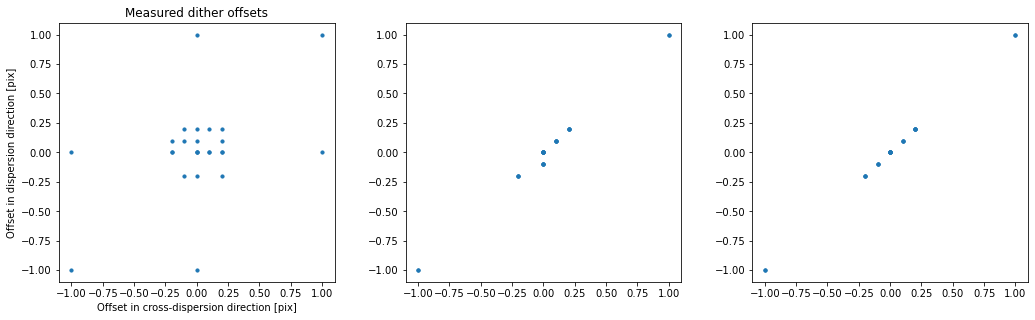

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.tight_layout(pad=4.0)
ax[0].scatter(movement[:, 1], movement[:,0], s=10)
ax[0].set_title('Measured dither offsets')
ax[0].set_xlabel('Offset in cross-dispersion direction [pix]')
ax[0].set_ylabel('Offset in dispersion direction [pix]')

ax[1].scatter(movement[:, 0], dither_positions['ypos'], s=10)
ax[2].scatter(movement[:, 1], dither_positions['xpos'], s=10)
plt.show()

In [9]:
distortions = np.median(JD.distortions[:, :, :], axis=0)

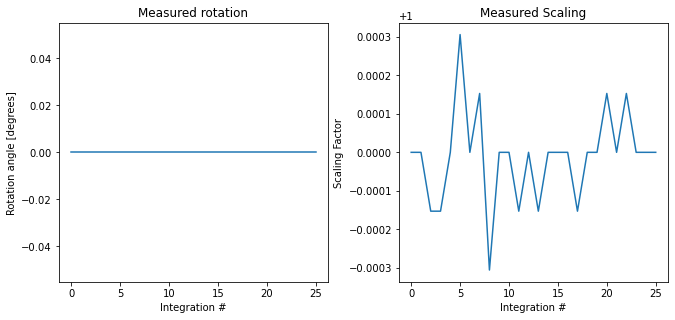

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(pad=4.0)
ax[0].plot(distortions[:, 0])
ax[1].plot(distortions[:, 1])
ax[0].set_title('Measured rotation')
ax[0].set_xlabel('Integration #')
ax[0].set_ylabel('Rotation angle [degrees]')
ax[1].set_title('Measured Scaling')
ax[1].set_xlabel('Integration #')
ax[1].set_ylabel('Scaling Factor')
plt.show()

## Using 2D anisotropic filtering before determining the movement of the dithered data ##
We can also look a the effect of bad pixel masking and cleaning of the spectral images has on the jitter determinations. In case of strong cosmic hits (not the case for the used data set) this probably will be the best option to make sure the strong signals of the cosmic hits do not influence the cross correlation method implemented to measure the telescope jitter. 

For details on the use of the <span style="color:#1F618D">CASCADe-filtering</span> package we refer to the notebooks and documentation of that package. To filter the spectral images, we first define a stack of filter kernels. Here we use the standard <span style="color:#1F618D">CASCADe</span> 2D filter kernel

In [11]:
FK = FilterKernel(configuration_file='banana_kernel.conf', path=CONFIG_PATH)
KERNEL_STACK = FK.kernel_stack

Next we create the directional filter kernel object and run the filtering on the spectral image cubes

In [12]:
DF = DirectionalFilter(sigma=4.5, max_iterations=39, acceptance_treshold=0.00001)
DF.load_filter_kernels(KERNEL_STACK)
DF.run_filter(spectral_image_cube, spectral_image_mask, spectral_image_uncertainty, ROI=ROI)

iteration: 1, number of flagged pixel: 5066
iteration: 2, number of flagged pixel: 7728
iteration: 3, number of flagged pixel: 1286
iteration: 4, number of flagged pixel: 326
iteration: 5, number of flagged pixel: 92
iteration: 6, number of flagged pixel: 26
iteration: 7, number of flagged pixel: 5
Final number of still flagged pixel after iterations: 0
The acceptance limit is: 4


The new pixel mask, the filtered data and the cleaned data can now be extracted from the DirectionalFilter

In [13]:
new_bad_pixel_mask = DF.return_updated_mask()
cleaned_image_cube, cleaned_image_cube_uncertainty, cleaned_image_cube_mask = DF.return_cleaned_data()
filtered_image_cube, filtered_image_cube_uncertainty, filtered_image_cube_mask = DF.return_filtered_data()

In [14]:
tracer = Tracer(configuration_file='tracer.conf', configuration_file_path=CONFIG_PATH)
tracer.run_tracer(cleaned_image_cube, cleaned_image_cube_mask)


In [15]:
print(tracer.roi.shape)
ROI_trace = tracer.roi[0,...]

(1, 416, 72)


In [16]:
JD = JitterDetector(configuration_file='jitter_detector.conf', configuration_file_path=CONFIG_PATH)
JD.run_jitter_detection(cleaned_image_cube,
                        cleaned_image_cube_mask, ROI)

Preprocessing Data
Determining Rotation and Scale


Reference Image:   0%|          | 0/2 [00:00<?, ?it/s]

Target Image:   0%|          | 0/26 [00:00<?, ?it/s]

Target Image:   0%|          | 0/26 [00:00<?, ?it/s]

Determiming Poining Movement


Reference Image:   0%|          | 0/1 [00:00<?, ?it/s]

Target Image:   0%|          | 0/26 [00:00<?, ?it/s]

Reference Image:   0%|          | 0/1 [00:00<?, ?it/s]

Target Image:   0%|          | 0/26 [00:00<?, ?it/s]

Select individual references of take median

In [17]:
movement = np.median(JD.source_shifts[:, :, :], axis=0)

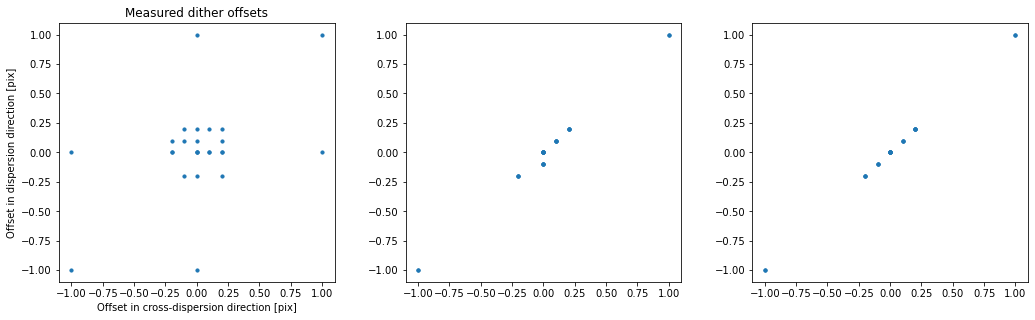

In [18]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.tight_layout(pad=4.0)
ax[0].scatter(movement[:, 1], movement[:,0], s=10)
ax[0].set_title('Measured dither offsets')
ax[0].set_xlabel('Offset in cross-dispersion direction [pix]')
ax[0].set_ylabel('Offset in dispersion direction [pix]')

ax[1].scatter(movement[:, 0], dither_positions['ypos'], s=10)
ax[2].scatter(movement[:, 1], dither_positions['xpos'], s=10)
plt.show()

In [19]:
distortions = np.median(JD.distortions, axis=0)

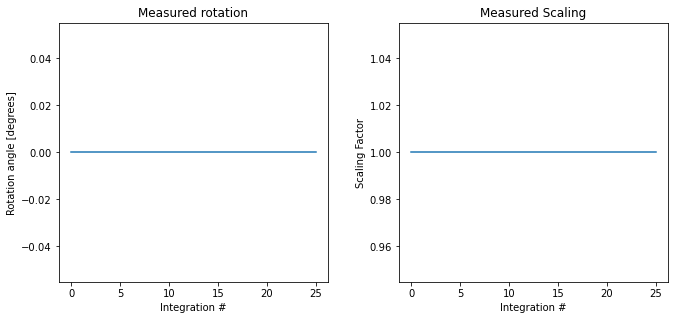

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(pad=4.0)
ax[0].plot(distortions[:, 0])
ax[1].plot(distortions[:, 1])
ax[0].set_title('Measured rotation')
ax[0].set_xlabel('Integration #')
ax[0].set_ylabel('Rotation angle [degrees]')
ax[1].set_title('Measured Scaling')
ax[1].set_xlabel('Integration #')
ax[1].set_ylabel('Scaling Factor')
plt.show()